<div style="text-align: center; line-height: 0; padding-top: 9px;">
  <img src="../../resources/logo.png" alt="Intellinum Bootcamp" style="width: 400px; height: 200px">
</div>

# Dataframes

Apache Spark&trade; allow you to use DataFrames to query large data files.

## In this lesson you:
* Learn about Spark DataFrames.
* Query large files using Spark DataFrames.
* Visualize query results using charts.



### Introducing DataFrames

Under the covers, DataFrames are derived from data structures known as Resilient Distributed Datasets (RDDs). RDDs and DataFrames are immutable distributed collections of data. Let's take a closer look at what some of these terms mean before we understand how they relate to DataFrames:

* **Resilient**: They are fault tolerant, so if part of your operation fails, Spark  quickly recovers the lost computation.
* **Distributed**: RDDs are distributed across networked machines known as a cluster.
* **DataFrame**: A data structure where data is organized into named columns, like a table in a relational database, but with richer optimizations under the hood. 

Without the named columns and declared types provided by a schema, Spark wouldn't know how to optimize the executation of any computation. Since DataFrames have a schema, they use the Catalyst Optimizer to determine the optimal way to execute your code.

* **Catalyst Optimizer**: Spark SQL is one of the newest and most technically involved components of Spark. It powers both SQL queries and the new DataFrame API. At the core of Spark SQL is the Catalyst optimizer, which leverages advanced programming language features (e.g. Scala’s pattern matching and quasiquotes) in a novel way to build an extensible query optimizer. To implement Spark SQL, a new extensible optimizer, Catalyst was designed, based on functional programming constructs in Scala. Catalyst’s extensible design had two purposes. First, we wanted to make it easy to add new optimization techniques and features to Spark SQL, especially for the purpose of tackling various problems we were seeing with big data (e.g., semistructured data and advanced analytics). Second, we wanted to enable external developers to extend the optimizer — for example, by adding data source specific rules that can push filtering or aggregation into external storage systems, or support for new data types. Catalyst supports both rule-based and cost-based optimization.


DataFrames were invented because the business community uses tables in a relational database, Pandas or R DataFrames, or Excel worksheets. A Spark DataFrame is conceptually equivalent to these, with richer optimizations under the hood and the benefit of being distributed across a cluster.

#### Interacting with DataFrames

Once created (instantiated), a DataFrame object has methods attached to it. Methods are operations one can perform on DataFrames such as filtering,
counting, aggregating and many others.

> <b>Example</b>: To create (instantiate) a DataFrame, use this syntax: `df = ...`

To display the contents of the DataFrame, apply a `show` operation (method) on it using the syntax `df.show()`. 

The `.` indicates you are *applying a method on the object*.

In working with DataFrames, it is common to chain operations together, such as: `df.select().filter().orderBy()`.  

By chaining operations together, you don't need to save intermediate DataFrames into local variables (thereby avoiding the creation of extra objects).

**Also note that you do not have to worry about how to order operations because the optimizier determines the optimal order of execution of the operations for you.**

`df.select(...).orderBy(...).filter(...)`

versus

`df.filter(...).select(...).orderBy(...)`

#### DataFrames and SQL

DataFrame syntax is more flexible than SQL syntax. Here we illustrate general usage patterns of SQL and DataFrames.

Suppose we have a data set we loaded as a table called `myTable` and an equivalent DataFrame, called `df`.
We have three fields/columns called `col_1` (numeric type), `col_2` (string type) and `col_3` (timestamp type)
Here are basic SQL operations and their DataFrame equivalents. 

Notice that columns in DataFrames are referenced by `col("<columnName>")`.

| SQL                                         | DataFrame (Python)                    |
| ------------------------------------------- | ------------------------------------- | 
| `SELECT col_1 FROM myTable`                 | `df.select(col("col_1"))`             | 
| `DESCRIBE myTable`                          | `df.printSchema()`                    | 
| `SELECT * FROM myTable WHERE col_1 > 0`     | `df.filter(col("col_1") > 0)`         | 
| `..GROUP BY col_2`                          | `..groupBy(col("col_2"))`             | 
| `..ORDER BY col_2`                          | `..orderBy(col("col_2"))`             | 
| `..WHERE year(col_3) > 1990`                | `..filter(year(col("col_3")) > 1990)` | 
| `SELECT * FROM myTable LIMIT 10`            | `df.limit(10)`                        |
| `display(myTable)` (text format)            | `df.show()`                           | 
| `display(myTable)` (html format)            | `display(df)`                         |

**Hint:** You can also run SQL queries with the special syntax `spark.sql("SELECT * FROM myTable")`

In this course you see many other usages of DataFrames. It is left up to you to figure out the SQL equivalents 
(left as exercises in some cases).

### Start Spark context
First thing first, let's create the sparkContext, if you don't understand this part, don't worry. We'll cover this in greater details in future lessons.

In [1]:
#MODE = "LOCAL"
MODE = "CLUSTER"

import sys
from pyspark.sql import SparkSession
from pyspark import SparkConf
import os
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark import SparkConf
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.storagelevel import StorageLevel
from matplotlib import interactive
import matplotlib.pyplot as plt
%matplotlib inline
interactive(True)
import json
import math
import numbers
import numpy as np
import plotly
plotly.offline.init_notebook_mode(connected=True)

sys.path.insert(0,'../../src')
from settings import *

try:
    fh = open('../../libs/pyspark24_py36.zip', 'r')
except FileNotFoundError:
    !AWS_ACCESS_KEY_ID={AWS_ACCESS_KEY} AWS_SECRET_ACCESS_KEY={AWS_SECRET_KEY} aws s3 cp s3://yuan.intellinum.co/bins/pyspark24_py36.zip ../../libs/pyspark24_py36.zip

try:
    spark.stop()
    print("Stopped a SparkSession")
except Exception as e:
    print("No existing SparkSession")

SPARK_DRIVER_MEMORY= "2G"
SPARK_DRIVER_CORE = "1"
SPARK_EXECUTOR_MEMORY= "1G"
SPARK_EXECUTOR_CORE = "1"
SPARK_EXECUTOR_INSTANCES = 6



conf = None
if MODE == "LOCAL":
    os.environ["PYSPARK_PYTHON"] = "/home/yuan/anaconda3/envs/pyspark24_py36/bin/python"
    conf = SparkConf().\
            setAppName("pyspark_day01_dataframe").\
            setMaster('local[*]').\
            set('spark.driver.maxResultSize', '0').\
            set('spark.jars', '../../libs/mysql-connector-java-5.1.45-bin.jar').\
            set('spark.jars.packages','net.java.dev.jets3t:jets3t:0.9.0,com.google.guava:guava:16.0.1,com.amazonaws:aws-java-sdk:1.7.4,org.apache.hadoop:hadoop-aws:2.7.1')
else:
    os.environ["PYSPARK_PYTHON"] = "./MN/pyspark24_py36/bin/python"
    conf = SparkConf().\
            setAppName("pyspark_day01_dataframe").\
            setMaster('yarn-client').\
            set('spark.executor.cores', SPARK_EXECUTOR_CORE).\
            set('spark.executor.memory', SPARK_EXECUTOR_MEMORY).\
            set('spark.driver.cores', SPARK_DRIVER_CORE).\
            set('spark.driver.memory', SPARK_DRIVER_MEMORY).\
            set("spark.executor.instances", SPARK_EXECUTOR_INSTANCES).\
            set('spark.sql.files.ignoreCorruptFiles', 'true').\
            set('spark.yarn.dist.archives', '../../libs/pyspark24_py36.zip#MN').\
            set('spark.sql.shuffle.partitions', '5000').\
            set('spark.default.parallelism', '5000').\
            set('spark.driver.maxResultSize', '0').\
            set('spark.jars.packages','net.java.dev.jets3t:jets3t:0.9.0,com.google.guava:guava:16.0.1,com.amazonaws:aws-java-sdk:1.7.4,org.apache.hadoop:hadoop-aws:2.7.1'). \
            set('spark.driver.maxResultSize', '0').\
            set('spark.jars', 's3://yuan.intellinum.co/bins/mysql-connector-java-5.1.45-bin.jar')
        

spark = SparkSession.builder.\
    config(conf=conf).\
    getOrCreate()


sc = spark.sparkContext

sc.addPyFile('../../src/settings.py')

sc=spark.sparkContext
hadoop_conf = sc._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
hadoop_conf.set("fs.s3a.access.key", AWS_ACCESS_KEY)
hadoop_conf.set("fs.s3a.secret.key", AWS_SECRET_KEY)
hadoop_conf.set("mapreduce.fileoutputcommitter.algorithm.version", "2")

def display(df, limit=10):
    return df.limit(limit).toPandas()

def dfTest(id, expected, result):
    assert str(expected) == str(result), "{} does not equal expected {}".format(result, expected)

No existing SparkSession


### Querying Data 
This lesson uses the `people-10m` data set, which is in Parquet format.

The data is fictitious; in particular, the Social Security numbers are fake.

Run the command below to see the contents of the `people-10m.parquet` file.

In [2]:
!AWS_ACCESS_KEY_ID={AWS_ACCESS_KEY} AWS_SECRET_ACCESS_KEY={AWS_SECRET_KEY} aws s3 ls s3://data.intellinum.co/bootcamp/common/people-10m.parquet/


2019-05-29 19:00:58          0 _SUCCESS
2019-05-29 19:00:44    8118248 part-00000-e69f0106-f446-443c-9049-d95493afe9a5-c000.snappy.parquet
2019-05-29 19:00:42    8118593 part-00001-e69f0106-f446-443c-9049-d95493afe9a5-c000.snappy.parquet
2019-05-29 19:00:44    8118640 part-00002-e69f0106-f446-443c-9049-d95493afe9a5-c000.snappy.parquet
2019-05-29 19:00:44    8118248 part-00003-e69f0106-f446-443c-9049-d95493afe9a5-c000.snappy.parquet
2019-05-29 19:00:42    8118843 part-00004-e69f0106-f446-443c-9049-d95493afe9a5-c000.snappy.parquet
2019-05-29 19:00:43    8118583 part-00005-e69f0106-f446-443c-9049-d95493afe9a5-c000.snappy.parquet
2019-05-29 19:00:43    8118249 part-00006-e69f0106-f446-443c-9049-d95493afe9a5-c000.snappy.parquet
2019-05-29 19:00:42    8119267 part-00007-e69f0106-f446-443c-9049-d95493afe9a5-c000.snappy.parquet
2019-05-29 19:00:42    8118869 part-00008-e69f0106-f446-443c-9049-d95493afe9a5-c000.snappy.parquet
2019-05-29 19:00:44    8118167 part-00009-e69f0106-f446-443c-9049-d95

In [3]:
peopleDF = spark.read.parquet("s3a://data.intellinum.co/bootcamp/common/people-10m.parquet")

In [27]:
display(peopleDF, 8)

,id,firstName,middleName,lastName,gender,birthDate,ssn,salary
0,838880,Margarete,Willetta,Shearwood,F,1997-03-24 05:00:00,961-82-3018,74468
1,828908,Almeda,Un,Standring,F,1969-10-31 05:00:00,925-45-8150,55688
2,842059,Launa,Jamie,Carling,F,1978-12-25 05:00:00,906-73-9805,92511
3,812971,Allie,Marlin,Guye,F,1986-12-02 05:00:00,934-31-9535,48451
4,802482,Anamaria,Keren,Benjefield,F,1982-08-10 04:00:00,999-45-4193,90330
5,811453,Fay,Ethyl,Charrisson,F,1996-12-30 05:00:00,942-57-6945,84103
6,816555,Estela,Cathy,Cleveley,F,1958-03-08 05:00:00,976-50-7231,54632
7,829473,Akilah,Leola,Grier,F,1995-01-04 05:00:00,941-54-1418,63966


Take a look at the schema with the `printSchema` method. This tells you the field name, field type, and whether the column is nullable or not (default is true).

In [5]:
peopleDF.printSchema()

root
 |-- id: integer (nullable = true)
 |-- firstName: string (nullable = true)
 |-- middleName: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthDate: timestamp (nullable = true)
 |-- ssn: string (nullable = true)
 |-- salary: integer (nullable = true)



Answer the following question:
> According to our data, which women were born after 1990?

Use the DataFrame `select` and `filter` methods.

In [6]:
from pyspark.sql.functions import year
display(
  peopleDF 
    .select("firstName","middleName","lastName","birthDate","gender") 
    .filter("gender = 'F'") 
    .filter(year("birthDate") > "1990")
)

,firstName,middleName,lastName,birthDate,gender
0,Margarete,Willetta,Shearwood,1997-03-24 05:00:00,F
1,Fay,Ethyl,Charrisson,1996-12-30 05:00:00,F
2,Akilah,Leola,Grier,1995-01-04 05:00:00,F
3,Jannie,Arlean,Aaron,1995-09-05 04:00:00,F
4,Evita,Heidi,Mears,1994-10-30 04:00:00,F
5,Williemae,Claudia,Crowley,1996-09-29 04:00:00,F
6,Evelina,Yee,Bucklan,1994-02-15 05:00:00,F
7,Oralia,Lyndsay,Patnelli,1995-12-13 05:00:00,F
8,Pasty,Marlana,Gresser,1994-01-09 05:00:00,F
9,Tangela,Marin,Mawne,1997-11-05 05:00:00,F


### Built-In Functions

Spark provides a number of <a href="https://spark.apache.org/docs/latest/api/scala/index.html#org.apache.spark.sql.functions$" target="_blank">built-in functions</a>, many of which can be used directly with DataFrames.  Use these functions in the `filter` expressions to filter data and in `select` expressions to create derived columns.

The following DataFrame statement finds women born after 1990; it uses the `year` function, and it creates a `birthYear` column on the fly.

In [30]:
display(
  peopleDF.select("firstName",
                  "middleName",
                  "lastName",
                  year("birthDate").alias('birthYear'),
                  "salary") 
    .filter(year("birthDate") > "1990") 
    .filter("gender = 'F' ")
)

,firstName,middleName,lastName,birthYear,salary
0,Margarete,Willetta,Shearwood,1997,74468
1,Fay,Ethyl,Charrisson,1996,84103
2,Akilah,Leola,Grier,1995,63966
3,Jannie,Arlean,Aaron,1995,95509
4,Evita,Heidi,Mears,1994,96999
5,Williemae,Claudia,Crowley,1996,77500
6,Evelina,Yee,Bucklan,1994,73325
7,Oralia,Lyndsay,Patnelli,1995,57709
8,Pasty,Marlana,Gresser,1994,53642
9,Tangela,Marin,Mawne,1997,83712


### Visualization

In this section, you'll learn how to visualize your spark dataframe using matplotlib and plotly

How many women were named Mary in each year?

In [8]:
marysDF = (peopleDF.select(year("birthDate").alias("birthYear")) 
  .filter("firstName = 'Mary' ") 
  .filter("gender = 'F' ") 
  .orderBy("birthYear") 
  .groupBy("birthYear") 
  .count()
)

In [9]:
display(marysDF,20)

,birthYear,count
0,1952,27
1,1953,25
2,1954,15
3,1955,23
4,1956,28
5,1957,29
6,1958,26
7,1959,28
8,1960,37
9,1961,29


To start the visualization process, we first create the dataset for Plotly from the spark dataframe and then call `plotly.offline.iplot`.

In [10]:
marys_pandas_DF = marysDF.toPandas()

__matplotlib__

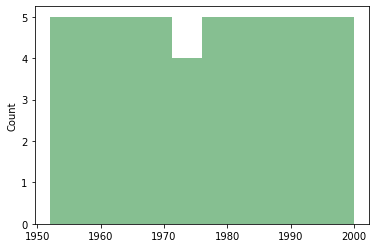

In [38]:
plt.hist(marys_pandas_DF['birthYear'], color='#86bf91')
plt.ylabel('Count');

__plotly__

Exercise: for some reason, plotly is not showing the correct result. Could you please fix it?


In [55]:
# TODO   
# 1. jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
# 2. change notebook to 'trusted'

data = [plotly.graph_objs.Histogram(x=list(marys_pandas_DF['birthYear']),name="Plot")]
plotly.offline.plot(data)

'temp-plot.html'

Compare popularity of two names from 1990.

In [13]:
from pyspark.sql.functions import col
dordonDF = (peopleDF 
  .select(year("birthDate").alias("birthYear"), "firstName") 
  .filter((col("firstName") == 'Donna') | (col("firstName") == 'Dorothy')) 
  .filter("gender == 'F' ") 
  .filter(year("birthDate") > 1990) 
  .orderBy("birthYear") 
  .groupBy("birthYear", "firstName") 
  .count()
)

In [14]:
display(dordonDF) # html form

,birthYear,firstName,count
0,1991,Donna,27
1,1991,Dorothy,25
2,1992,Donna,30
3,1992,Dorothy,39
4,1993,Donna,22
5,1993,Dorothy,28
6,1994,Donna,26
7,1994,Dorothy,21
8,1995,Dorothy,26
9,1995,Donna,33


In [37]:
dordonDF.show() # text form

+---------+---------+-----+
|birthYear|firstName|count|
+---------+---------+-----+
|     1991|  Dorothy|   25|
|     1991|    Donna|   27|
|     1992|    Donna|   30|
|     1992|  Dorothy|   39|
|     1993|    Donna|   22|
|     1993|  Dorothy|   28|
|     1994|  Dorothy|   21|
|     1994|    Donna|   26|
|     1995|    Donna|   33|
|     1995|  Dorothy|   26|
|     1996|    Donna|   23|
|     1996|  Dorothy|   19|
|     1997|  Dorothy|   24|
|     1997|    Donna|   36|
|     1998|    Donna|   28|
|     1998|  Dorothy|   33|
|     1999|    Donna|   22|
|     1999|  Dorothy|   25|
|     2000|  Dorothy|    4|
|     2000|    Donna|    2|
+---------+---------+-----+



Exercise: Could you please come up with some visualization for `dordonDF`? 

In [45]:
#dordon_pandas_DF = dordonDF.toPandas()
#plt.bar(dordon_pandas_DF['birthYear'], height=dordon_pandas_DF['count'], color='#86bf91')
#plt.ylabel('Count');

### Temporary Views

In DataFrames, <b>temporary views</b> are used to make the DataFrame available to SQL, and work with SQL syntax seamlessly.

A temporary view gives you a name to query from SQL, but unlike a table it exists only for the duration of your Spark Session. As a result, the temporary view will not carry over when you restart the cluster or switch to a new notebook. It also won't show up in the Data button on the menu on the left side of a Databricks notebook which provides easy access to databases and tables.

The statement in the following cells create a temporary view containing the same data.

In [15]:
peopleDF.createOrReplaceTempView("People10M")

To view the contents of temporary view, use select notation.

In [16]:
display(spark.sql("SELECT * FROM  People10M WHERE firstName = 'Donna' "))

,id,firstName,middleName,lastName,gender,birthDate,ssn,salary
0,2595,Donna,Carola,Philipot,F,1964-09-26 04:00:00,999-24-1601,63160
1,1043084,Donna,Lidia,Clutram,F,1961-03-10 05:00:00,967-76-9652,100016
2,1896797,Donna,Pamala,Roundtree,F,1989-10-15 04:00:00,907-98-6146,67723
3,3756906,Donna,Jeanene,Aspland,F,1978-05-11 04:00:00,984-45-5643,56676
4,262706,Donna,Shyla,Khosa,F,1957-12-06 05:00:00,990-45-5675,66505
5,2788507,Donna,Candida,Antusch,F,1979-07-05 04:00:00,956-38-1959,65484
6,3533125,Donna,Amira,Dillimore,F,1961-07-17 04:00:00,904-82-2741,66073
7,2625872,Donna,Krissy,Leate,F,1971-10-21 04:00:00,962-86-1002,73115
8,324633,Donna,Eulalia,Stonestreet,F,1964-04-09 05:00:00,971-10-4374,106777
9,1945549,Donna,Tenisha,Wellard,F,1994-07-05 04:00:00,931-97-5701,51420


Create a DataFrame with a more specific query.

In [17]:
womenBornAfter1990DF = (peopleDF 
  .select("firstName", "middleName", "lastName",year("birthDate").alias("birthYear"), "salary") 
  .filter(year("birthDate") > 1990) 
  .filter("gender = 'F' ") 
)

Create Temporary Views from the `womenBornAfter1990DF` DataFrame

In [18]:
womenBornAfter1990DF.createOrReplaceTempView("womenBornAfter1990")

Once a temporary view has been created, it can be queried as if it were a table. 

Find out how many Marys are in the WomenBornAfter1990 DataFrame.

In [19]:
display(spark.sql("SELECT count(*) FROM womenBornAfter1990 where firstName = 'Mary' "))

,count(1)
0,268


## Exercise 1

Create a DataFrame called top10FemaleFirstNamesDF that contains the 10 most common female first names out of the people data set.

* `firstName` - the first name
* `total` - the total number of rows with that first name

**Hint:** 
* You may need to break ties by using firstName because some of the totals are identical.
* To restrict the number of names to 10, you need to use the `limit(10)` method.
* You also need to use the `agg()` method to do a count of `firstName` and give it an alias.
* The `agg()` method is applied after the `groupBy` since it requires column values to be collected in some fashion.
* You will need to import the `count` and `desc` methods in Scala or Python, as appropriate.

Display the results.

### Step 1
Create a DataFrame called `top10FemaleFirstNamesDF` and display the results.

In [52]:
# TODO
from pyspark.sql.functions import count, desc

top10FemaleFirstNamesDF = (peopleDF.select("firstname")
                           .filter("gender='F'") 
                           .groupBy("firstName") 
                           .count() 
                           .orderBy(desc("count"), "firstName") 
                           .limit(10))

In [53]:
top10FemaleNamesDF = top10FemaleFirstNamesDF.orderBy("firstName")

display(top10FemaleNamesDF)

,firstName,count
0,Alesha,1368
1,Alice,1384
2,Bridgette,1373
3,Cristen,1375
4,Jacquelyn,1381
5,Katherin,1373
6,Lashell,1387
7,Louie,1382
8,Lucille,1384
9,Sharyn,1394


In [54]:
from pyspark.sql import Row
results = top10FemaleNamesDF.collect()

dfTest("DF-L2-names-0", Row(firstName=u"Alesha",    total=1368), results[0])  
dfTest("DF-L2-names-1", Row(firstName=u"Alice",     total=1384), results[1])
dfTest("DF-L2-names-2", Row(firstName=u"Bridgette", total=1373), results[2])
dfTest("DF-L2-names-3", Row(firstName=u"Cristen",   total=1375), results[3])
dfTest("DF-L2-names-4", Row(firstName=u"Jacquelyn", total=1381), results[4])
dfTest("DF-L2-names-5", Row(firstName=u"Katherin",  total=1373), results[5])
dfTest("DF-L2-names-6", Row(firstName=u"Lashell",   total=1387), results[6])
dfTest("DF-L2-names-7", Row(firstName=u"Louie",     total=1382), results[7])
dfTest("DF-L2-names-8", Row(firstName=u"Lucille",   total=1384), results[8])
dfTest("DF-L2-names-9", Row(firstName=u"Sharyn",    total=1394), results[9]) 

print("Tests passed!")

AssertionError: Row(firstName='Alesha', count=1368) does not equal expected Row(firstName='Alesha', total=1368)

### Step 2

Convert the DataFrame to a temporary view and display the contents of the temporary view.

In [23]:
# TODO
top10FemaleFirstNamesDF.createOrReplaceTempView("Top10FemaleFirstNames")
resultsDF = spark.sql(" SELECT * FROM Top10FemaleFirstNames ")
display(resultsDF)

,firstName,count
0,Sharyn,1394
1,Lashell,1387
2,Alice,1384
3,Lucille,1384
4,Louie,1382
5,Jacquelyn,1381
6,Cristen,1375
7,Bridgette,1373
8,Katherin,1373
9,Alesha,1368


&copy; 2019 [Intellinum Analytics, Inc](http://www.intellinum.co). All rights reserved.<br/>